# Learning and Decision Making

## Laboratory 3: Partially observable Markov decision problems

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. Modeling

Consider once again the princess saving problem described in the Homework and which you described as a POMDP.

Recall that:

* The princess can be in any one of two towers: Tower *A* and Tower *B*. The knight must decide which tower do invade to rescue the princess. 

* The knight can try to _peer_ at the towers, to figure out where the princess may be. 

* When the agent peers, it sees the princess in the right location with a probability of 0.9, and at the wrong location with probability 0.1.

* Whenever the knight invades a tower, the "world" resets.

Consider throughout that $\gamma=0.9$.

---

#### Activity 1.        

Implement your POMDP in Python. In particular,

* Create a list with all the states;
* Create a list with all the actions;
* Create a list with all the observations
* For each action, define a `numpy` array with the corresponding transition probabilities;
* For each action, define a `numpy` array with the corresponding observation probabilities;
* Define a `numpy` array with the cost describing the problem. Make sure that the costs lie in the interval [0,1] and that the cost for peering is in the middle between the cost for saving and being captured.

The order for the states and actions used in the transition probability and cost matrices should match that in the lists of states and actions. 

**Note**: Don't forget to import `numpy`.

---

In [12]:
import numpy as np

X = ["A", "B"] #princess at A or B

A = ["Invade A","Invade B","Peer"] #invade blind or invade observe

Z = ["Sees A","Sees B","See Nothing"] #princes observed at A or B or dont observe

PIa=np.array([[0.5, 0.5],
              [0.5, 0.5]])

PIb=np.array([[0.5, 0.5],
              [0.5, 0.5]])

Pp=np.array([[1,0],
             [0,1]])

Oa=np.array([[0, 0, 1],
              [0, 0, 1]])

Ob=np.array([[0, 0, 1],
              [0, 0, 1]])

On=np.array([[0.9, 0.1, 0],
             [0.1, 0.9, 0]])

C=np.array([[0, 1, 0.5],
            [1, 0, 0.5]])


### 2. Sampling

You are now going to sample random trajectories of your POMDP and observe the impact it has on the corresponding belief.

---

#### Activity 2.

Generate a random POMDP trajectory using a uniformly random policy. In particular, from a random initial state $x_0$ generate:

1. A sequence of 10,000 states by selecting the actions uniformly at random;
2. The corresponding sequence of 10,000 actions;
3. The corresponding sequence of 10,000 observations.

---

In [13]:
from numpy import random as rand
states = []
actions = []
observations = []
step=0

P_action = {"Invade A" : PIa, "Invade B" : PIb, "Peer" : Pp}
O_action = {"Invade A" : Oa, "Invade B" : Ob, "Peer" : On}

state = rand.choice(X)
states.append(state)

while step < 10000:
    action = rand.choice(A)
    actions.append(action)
    
    
    observation = rand.choice(Z, p=O_action[action][X.index(state)])
    observations.append(observation)  
    
    
    state = rand.choice(X, p=P_action[action][X.index(state)])
    states.append(state)
    
   
    
    step += 1

del(states[-1])
print(len(actions))
print(len(states))
print(len(observations))
print(actions[0])
print(states[0])
print(observations[0])

10000
10000
10000
Invade A
B
See Nothing


---

#### Activity 3.

For the POMDP trajectory generated in Activity 2, compute the corresponding sequence of beliefs, assuming that the initial belief is $\mathbf{b}_0=[0.5, 0.5]$. Report the resulting beliefs, ignoring duplicate beliefs or beliefs whose distance is smaller than $10^{-3}$.

**Note 1:** You may want to define a function `belief_update` that receives a belief, an action and an observation and returns the updated belief.

**Note 2:** To compute the distance between vectors, you may find useful `numpy`'s function `linalg.norm`.


---

In [14]:
from numpy import linalg as ln
belief = np.array([0.5,0.5])
beliefs = []
beliefs.append(belief)

def belief_update(belief, action, observation):
    Pa = P_action[action] #For a given action finds the transition prob for that action
    diag_obs = np.diag(O_action[action][:, Z.index(observation)]) #given an action finds the observation prob and select an observation
    
    bt0 = (belief.dot(Pa)).dot(diag_obs)
    bt = bt0/np.sum(bt0)
    
    return bt

for step in range(10000):
    new_belief = belief_update(belief, actions[step], observations[step])
    if all(abs(ln.norm(new_belief - b)) > 1e-3 for b in beliefs):
        beliefs.append(new_belief)
    belief = new_belief
    
print(beliefs)





[array([0.5, 0.5]), array([0.1, 0.9]), array([0.01219512, 0.98780488]), array([0.9, 0.1]), array([0.98780488, 0.01219512]), array([0.99863014, 0.00136986]), array([0.00136986, 0.99863014]), array([1.52392563e-04, 9.99847607e-01]), array([9.99847607e-01, 1.52392563e-04])]


### 3. Solution methods

In this section you are going to compare different non-exact solution methods.

---

#### Activity 4

Compute the solution for the underlying MDP and report the corresponding optimal policy and optimal cost-to-go. 

** Note:** You may reuse code from previous labs.

---

In [15]:
gamma = 0.9

cost_invade_A = np.reshape(C[:,0], (2,1))
cost_invade_B = np.reshape(C[:,1], (2,1))
cost_peek = np.reshape(C[:,2], (2,1))

J = np.zeros((2,1))
err = 1

while err > 1e-8:
    Qa = cost_invade_A + gamma*PIa.dot(J)
    Qb = cost_invade_B + gamma*PIb.dot(J)
    Qp = cost_peek + gamma*Pp.dot(J)
   
    Jnew = np.min((Qa, Qb, Qp), axis=0)
    err = np.linalg.norm(Jnew - J)
    J = Jnew

print("Cost-to-go: \n", J)

quit = False
pi = np.ones((2, 1)) / 2

while not quit:
    pinew = np.zeros((2,3))
    pinew[:, 0, None] = np.isclose(Qa, np.min([Qa, Qb, Qp], axis=0), atol=1e-8, rtol=1e-8).astype(int)
    pinew[:, 1, None] = np.isclose(Qb, np.min([Qa, Qb, Qp], axis=0), atol=1e-8, rtol=1e-8).astype(int)
    pinew[:, 2, None] = np.isclose(Qp, np.min([Qa, Qb, Qp], axis=0), atol=1e-8, rtol=1e-8).astype(int)
    
    pinew = pinew / np.sum(pinew, axis=1, keepdims = True)
    
    quit = (pi == pinew).all()
    
    pi = pinew
print(pi)


Cost-to-go: 
 [[0.]
 [0.]]
[[1. 0. 0.]
 [0. 1. 0.]]


---

#### Activity 5

For each of the beliefs computed in Activity 3, compute the action prescribed by:

* The MLS heuristic;
* The AV heuristic;
* The Q-MDP heuristic.

---

In [16]:
Q = np.array([Qa, Qb, Qp])

mls = [] 
av = []
q_mdp = []

for b in beliefs:
    mls.append(A[np.argmax(b)])
    av.append(A[np.argmax(b.dot(pi))])
    q_mdp.append(A[np.argmin(b.dot(Q))])
    
print(mls)
print(av)
print(q_mdp)

    


['Invade A', 'Invade B', 'Invade B', 'Invade A', 'Invade A', 'Invade A', 'Invade B', 'Invade B', 'Invade A']
['Invade A', 'Invade B', 'Invade B', 'Invade A', 'Invade A', 'Invade A', 'Invade B', 'Invade B', 'Invade A']
['Invade A', 'Invade B', 'Invade B', 'Invade A', 'Invade A', 'Invade A', 'Invade B', 'Invade B', 'Invade A']


---

#### Activity 6

Suppose that the optimal cost-to-go function for the POMDP can be represented using the $\alpha$-vectors

$$
\left\{
\begin{bmatrix}
2.795\\
3.795
\end{bmatrix},
\begin{bmatrix}
3.795\\
2.795
\end{bmatrix},
\begin{bmatrix}
3.105\\
3.105
\end{bmatrix}\right\}$$

corresponding to the actions 'Invade Tower A', 'Invade Tower B' and 'Peer', respectively. Represent the optimal cost-to-go function and compare the optimal policy with the MDP heuristics from Activity 5 in the beliefs computed in Activity 3.

** Note: ** Don't forget to import `matplotlib`, and use the magic `%matplotlib notebook`.

---

<IPython.core.display.Javascript object>


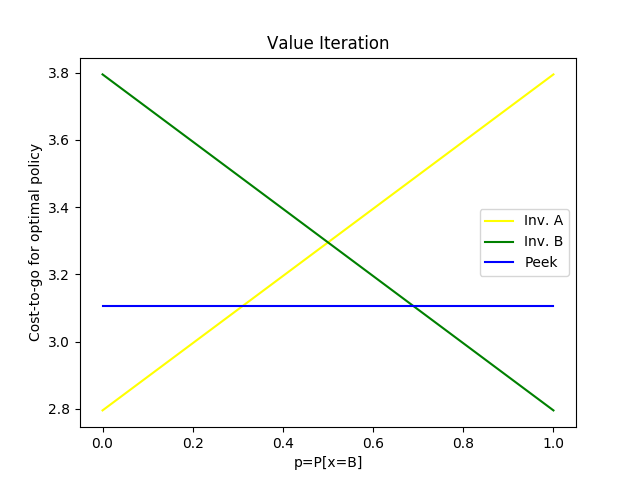

<IPython.core.display.Javascript object>


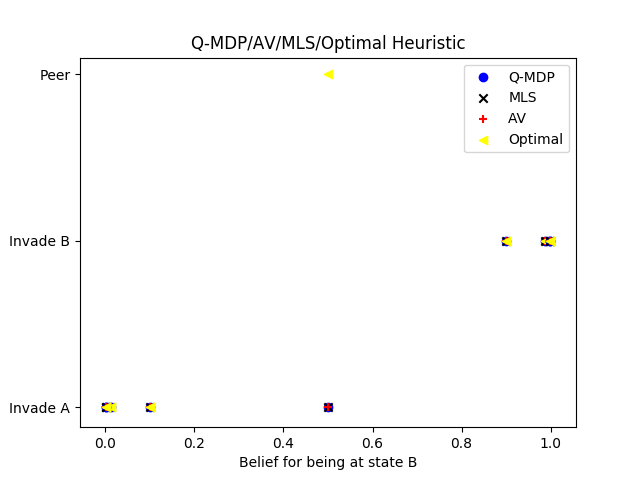

0
Peer
1
Invade B
1
Invade B
0
Invade A
0
Invade A
0
Invade A
1
Invade B
1
Invade B
0
Invade A


In [21]:

import matplotlib.pyplot as plt

%matplotlib notebook

plt1 = plt.figure(1)

#Probability Value
Opt_x = np.array([0, 1])

#Cost-to-go value for given action
Opt_a = np.array([2.795, 3.795])
Opt_b = np.array([3.795, 2.795])
Opt_p = np.array([3.105, 3.105])
Opt=np.array([Opt_a.reshape((2,1)),Opt_b.reshape((2,1)), Opt_p.reshape((2,1))])



#Plot for optimal cost-to-go
plt.plot(Opt_x, Opt_a, color = 'yellow')
plt.plot(Opt_x, Opt_b, color = 'green')
plt.plot(Opt_x, Opt_p, color = 'blue')
plt.legend(['Inv. A', 'Inv. B', 'Peek'])
plt.title("Value Iteration")
plt.xlabel("p=P[x=B]")
plt.ylabel("Cost-to-go for optimal policy")

plt1.show()

plt2 = plt.figure(2)

#Plot for MLS heuristic
#change y axis to actions
y = np.arange(3)
plt.yticks(y, A)
for i in range(len(beliefs)):
    plt.scatter(beliefs[i][1], A.index(q_mdp[i]), marker="o", c="blue")
    plt.scatter(beliefs[i][1], A.index(mls[i]), marker="x", c="black")
    plt.scatter(beliefs[i][1], A.index(av[i]), marker="+", c="red")
    plt.scatter(beliefs[i][1], np.argmin(beliefs[i].dot(Opt)), marker="<", c="yellow")
    print(A.index(av[i]))
    print(A[np.argmin(beliefs[i].dot(Opt))])
plt.legend(['Q-MDP', 'MLS', 'AV', 'Optimal'])
plt.title("Q-MDP/AV/MLS/Optimal Heuristic")   
plt.xlabel("Belief for being at state B")
plt.ylabel("Action")
plt2.show()
#plot of optimal heurisstic is wrong, he choses the same actions but plot it in a different way




In [8]:
print("Since MLS, AV and Q-MDP heuristics calculation results in the same actions, figure 2 represents all the heuristics.\nWe can see that this calculations follows the optimal policy plotted in figure 1 and 2")


Since MLS, AV and Q-MDP heuristics calculation results in the same actions, figure 2 represents all the heuristics.
We can see that this calculations follows the optimal policy plotted in figure 1 and 2
